# **Import modules**

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# **Image transformation**

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
}

In [3]:
data_dir = "/kaggle/input/brisc2025/brisc2025/classification_task"

img_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train', 'test']}

In [4]:
batch_size = 32

dataloaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size= batch_size, shuffle=True, num_workers=2) for x in ['train','test']}
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = img_datasets['train'].classes
class_names

{'train': 5000, 'test': 1000}


['glioma', 'meningioma', 'no_tumor', 'pituitary']

# **Custom CNN**


Epoch 1/20
------------------------------
train Loss: 0.7103 Acc: 0.7178
test Loss: 0.4741 Acc: 0.8020

Epoch 2/20
------------------------------
train Loss: 0.3742 Acc: 0.8526
test Loss: 0.3275 Acc: 0.8620

Epoch 3/20
------------------------------
train Loss: 0.2650 Acc: 0.8942
test Loss: 0.3698 Acc: 0.8580

Epoch 4/20
------------------------------
train Loss: 0.2037 Acc: 0.9258
test Loss: 0.2138 Acc: 0.9300

Epoch 5/20
------------------------------
train Loss: 0.1388 Acc: 0.9524
test Loss: 0.1616 Acc: 0.9420

Epoch 6/20
------------------------------
train Loss: 0.1067 Acc: 0.9626
test Loss: 0.1658 Acc: 0.9520

Epoch 7/20
------------------------------
train Loss: 0.0796 Acc: 0.9726
test Loss: 0.1658 Acc: 0.9510

Epoch 8/20
------------------------------
train Loss: 0.0716 Acc: 0.9748
test Loss: 0.1708 Acc: 0.9440

Epoch 9/20
------------------------------
train Loss: 0.0474 Acc: 0.9856
test Loss: 0.1980 Acc: 0.9490

Epoch 10/20
------------------------------
train Loss: 0.0482 A

<Figure size 800x600 with 0 Axes>

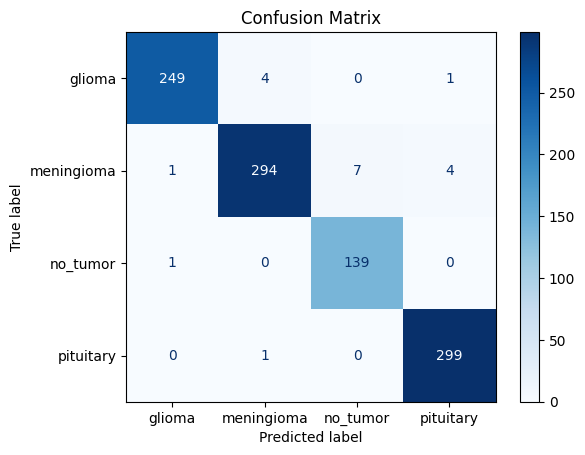

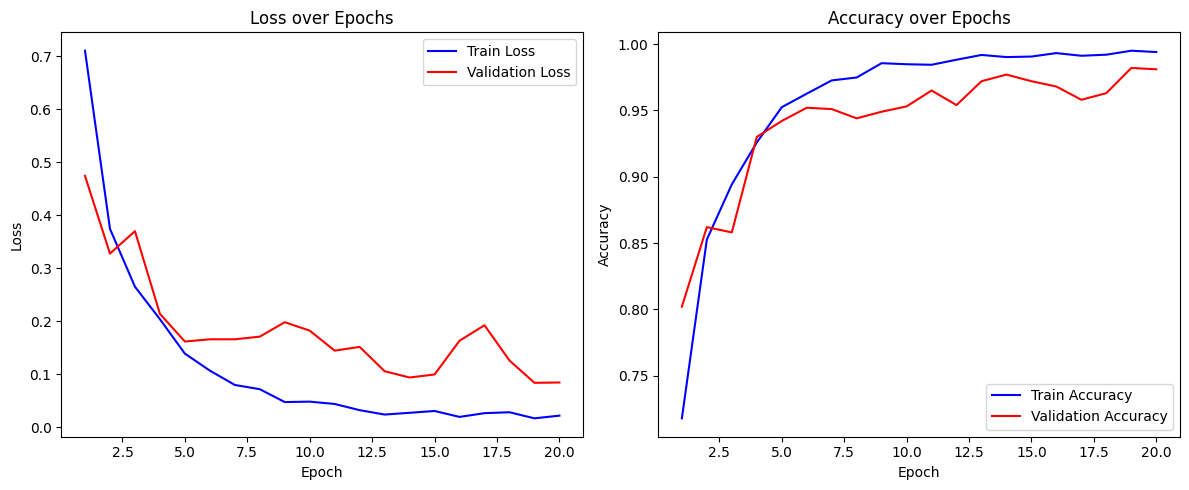

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128*16*16, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)

        return x


model = CustomCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)


num_epochs = 20
train_lossess = []
val_lossess = []
train_accuracies = []
val_accuracies = []
best_model_wts = model.state_dict()
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-'*30)

    for phase in ['train', 'test']:
        if phase=='train':
            model.train()

        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase=='train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase =='train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase =='train':
            train_lossess.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())

        else:
            val_lossess.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

model.load_state_dict(best_model_wts)

print("\nTraining complete")
print(f"Best validation Accuracy: {best_acc:.4f}")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs,1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_lossess, 'b-', label='Train Loss')
plt.plot(epochs, val_lossess, 'r-', label='Validation Loss') 
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy') 
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
torch.save(model.state_dict(),'hybrid_model_weights.pth')

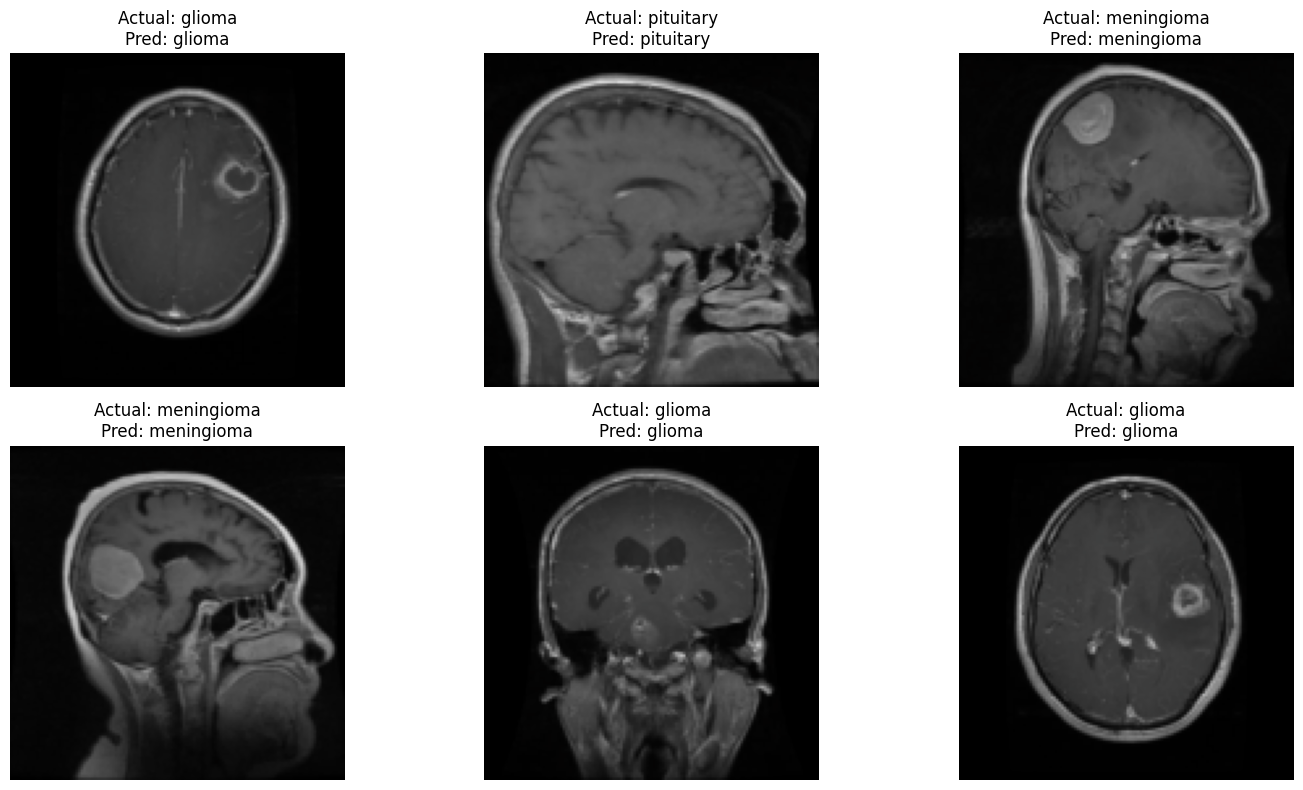

In [17]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np

# Define unnormalize transform if normalization was used
# (adjust these values based on your original transform)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# Set model to evaluation mode
model.eval()

# Get test dataset and class names
test_dataset = dataloaders['test'].dataset
class_names = test_dataset.classes

# Select 6 random images
indices = random.sample(range(len(test_dataset)), 6)

# Create plot
plt.figure(figsize=(15, 8))

for i, idx in enumerate(indices):
    image, label = test_dataset[idx]

    # Move image to device and predict
    input_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    # Unnormalize image for display
    unnorm_img = image * std + mean
    unnorm_img = torch.clamp(unnorm_img, 0, 1)  # Clip values to [0,1]
    img_np = unnorm_img.permute(1, 2, 0).cpu().numpy()  # CHW to HWC

    # Plot image with prediction
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"Actual: {class_names[label]}\nPred: {class_names[pred.item()]}", fontsize=12)

plt.tight_layout()
plt.show()
